## DATA 620 - Project 2: Marvel Social Network Universe

**By Eddie Xu and Mohamed Hassan-El Serafi**

For this project:

Instructions:

Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
What can you infer about each of the distinct groups?
You may work in a small group on the project.

Your code and analysis should be delivered in an IPython Notebook by end of day Monday 

[Kaggle data link](https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network)

In [21]:
# load packages
import pandas as pd
import numpy as np
import networkx as nx
import random
import movecolumn as mc
from scipy import stats
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,10)

# import packages to set up bipartite graph and communities
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout
from community import community_louvain
import matplotlib.cm as cm

### Data Selection

In [ ]:
edges_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/edges.csv'
network_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/hero-network.csv'
nodes_url = 'https://raw.githubusercontent.com/eddiexunyc/web_analytics_work/refs/heads/main/Project%202/Resources/nodes.csv' 

# extract data
nodes_raw = pd.read_csv(nodes_url)
edges_raw = pd.read_csv(edges_url)
network_raw = pd.read_csv(network_url)

### Exploratory Data Analysis

#### Nodes

In [ ]:
nodes_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node    19090 non-null  object
 1   type    19090 non-null  object
dtypes: object(2)
memory usage: 298.4+ KB


In [ ]:
nodes_raw.head(10)

node   type
0               2001 10  comic
1                2001 8  comic
2                2001 9  comic
3  24-HOUR MAN/EMMANUEL   hero
4  3-D MAN/CHARLES CHAN   hero
5      4-D MAN/MERCURIO   hero
6               8-BALL/   hero
7                 A '00  comic
8                 A '01  comic
9                 A 100  comic

In [ ]:
nodes_profile = ProfileReport(nodes_raw, title="Nodes Profiling Report")
nodes_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Edges

In [ ]:
edges_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero    96104 non-null  object
 1   comic   96104 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
edges_raw.head(10)

hero     comic
0  24-HOUR MAN/EMMANUEL    AA2 35
1  3-D MAN/CHARLES CHAN     AVF 4
2  3-D MAN/CHARLES CHAN     AVF 5
3  3-D MAN/CHARLES CHAN     COC 1
4  3-D MAN/CHARLES CHAN    H2 251
5  3-D MAN/CHARLES CHAN    H2 252
6  3-D MAN/CHARLES CHAN  M/PRM 35
7  3-D MAN/CHARLES CHAN  M/PRM 36
8  3-D MAN/CHARLES CHAN  M/PRM 37
9  3-D MAN/CHARLES CHAN     WI? 9

In [ ]:
edges_profile = ProfileReport(edges_raw, title="Edges Profiling Report")
edges_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Network

In [ ]:
network_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [ ]:
network_raw.head(10)

hero1                 hero2
0         LITTLE, ABNER        PRINCESS ZANDA
1         LITTLE, ABNER  BLACK PANTHER/T'CHAL
2  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
3         LITTLE, ABNER        PRINCESS ZANDA
4         LITTLE, ABNER  BLACK PANTHER/T'CHAL
5  BLACK PANTHER/T'CHAL        PRINCESS ZANDA
6  STEELE, SIMON/WOLFGA      FORTUNE, DOMINIC
7  STEELE, SIMON/WOLFGA   ERWIN, CLYTEMNESTRA
8  STEELE, SIMON/WOLFGA  IRON MAN/TONY STARK 
9  STEELE, SIMON/WOLFGA  IRON MAN IV/JAMES R.

In [ ]:
network_profile = ProfileReport(network_raw, title="Network Profiling Report")
network_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Transformation

In [22]:
# For unipartite graph
# create the hero network
Thor_network = network_raw[network_raw['hero1'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_network = network_raw[network_raw['hero1'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_network = network_raw[network_raw['hero1'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_network = network_raw[network_raw['hero1'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_network = network_raw[network_raw['hero1'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger networks into one
network_subset = pd.concat([Thor_network, Cap_network, IronMan_network, BlackWidow_network, Hulk_network],axis = 0)

In [23]:
## for bipartite graph
# create the avenger list
avenger_list = ['THOR/DR. DONALD BLAK', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'BLACK WIDOW/NATASHA', 'HULK/DR. ROBERT BRUC']

# extract edges of original avengers except for hawkeyes as there is no data for it
Thor_edge = edges_raw[edges_raw['hero'].str.contains('THOR/DR. DONALD BLAK')].sample(25)
Cap_edge = edges_raw[edges_raw['hero'].str.contains('CAPTAIN AMERICA')].sample(25)
IronMan_edge = edges_raw[edges_raw['hero'].str.contains('IRON MAN/TONY STARK')].sample(25)
BlackWidow_edge = edges_raw[edges_raw['hero'].str.contains('BLACK WIDOW/NATASHA')].sample(25)
Hulk_edge = edges_raw[edges_raw['hero'].str.contains('HULK/DR. ROBERT BRUC')].sample(25)

# combine all avenger edges into one
edge_subset = pd.concat([Thor_edge, Cap_edge, IronMan_edge, BlackWidow_edge, Hulk_edge],axis = 0)
edge_list = list(zip(edge_subset['hero'], edge_subset['comic']))

# create the comic list
comic_list = edge_subset['comic']

### Network Analysis

#### Unipartite Network

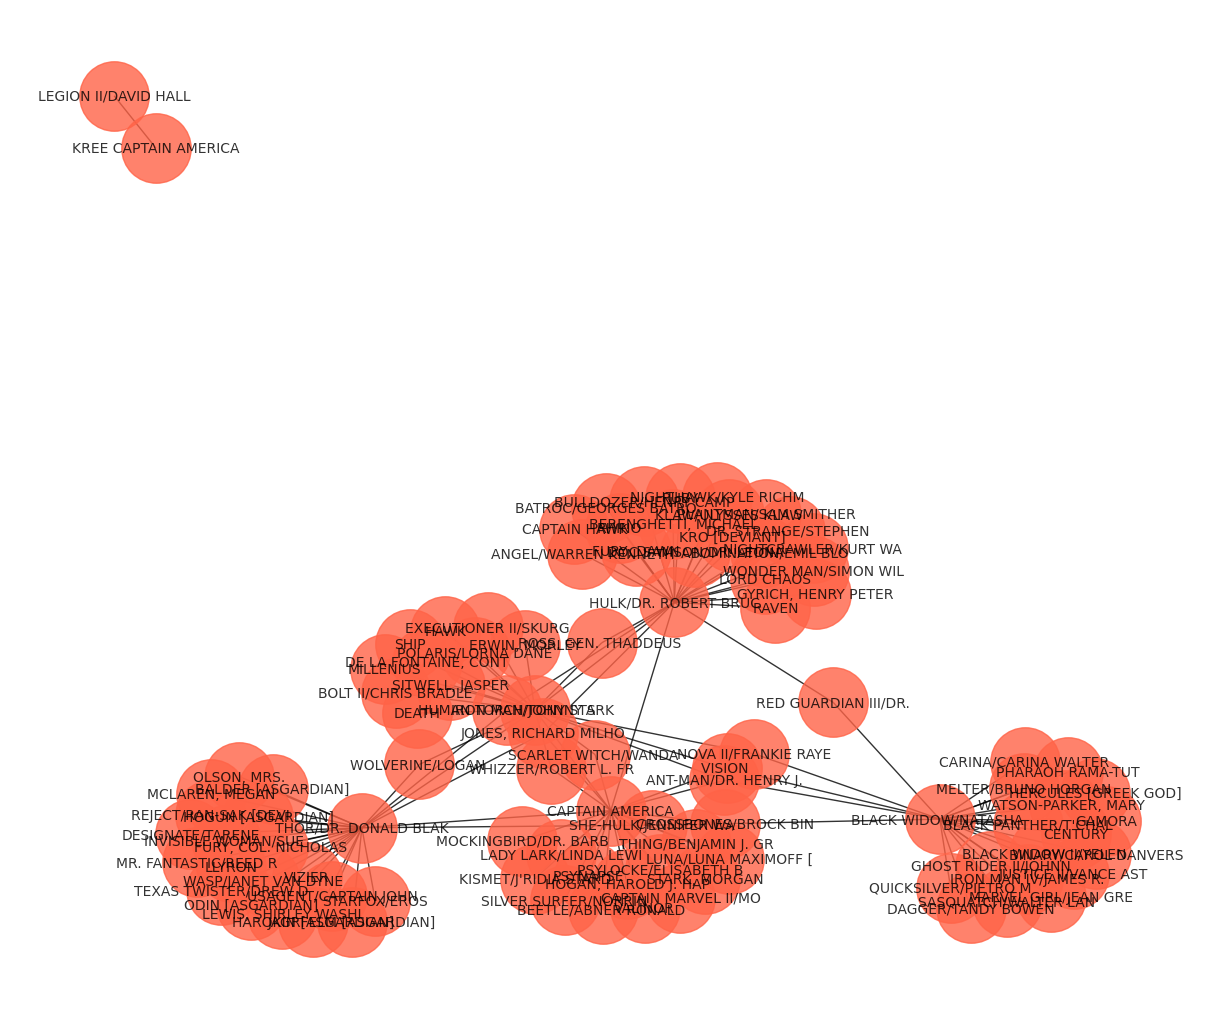

In [31]:
G=nx.from_pandas_edgelist(network_subset, 'hero1', 'hero2')
pos = nx.spring_layout(G, seed=648)  # Seed layout for reproducible node positions
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="tomato", font_size=10, font_color="black", edge_color="black", alpha=0.8)

plt.show()

#### Network Centrality

In [ ]:
# get the degree centrality
avenger_centrality = nx.degree_centrality(G)
sorted_avenger_centrality = sorted(avenger_centrality, key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Degree Centrality:", sorted_avenger_centrality)
avenger_centrality

Top Avenger by Degree Centrality: ['GYRICH, HENRY PETER', 'EXECUTIONER II/SKURG', 'FURY, COL. NICHOLAS ', 'HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC', 'LUNA/LUNA MAXIMOFF [', 'JUSTICE II/VANCE AST', 'QUICKSILVER/PIETRO M', 'BULLDOZER/HENRY CAMP', 'RUBY', 'FURY, DAWN', 'STARFOX/EROS', 'STARK, MORGAN', 'USAGENT/CAPTAIN JOHN', 'PSYLOCKE/ELISABETH B', 'PSYNAPSE', 'MR. FANTASTIC/REED R', 'IRON MAN/TONY STARK ', 'KREE CAPTAIN AMERICA', 'CROSSBONES/BROCK BIN', 'ERWIN, MORLEY', 'IRON MAN IV/JAMES R.', 'KRO [DEVIANT]', 'DR. STRANGE/STEPHEN ', 'JONES, RICHARD MILHO', 'WOLVERINE/LOGAN ', 'HOGUN [ASGARDIAN]', 'MOCKINGBIRD/DR. BARB', 'HOGAN, HAROLD J. HAP', 'NOVA II/FRANKIE RAYE', 'POLARIS/LORNA DANE', 'BOLT II/CHRIS BRADLE', 'ROSS, GEN. THADDEUS ', 'WONDER MAN/SIMON WIL', 'LORD CHAOS', 'DOC SAMSON/DR. LEONA', 'INVISIBLE WOMAN/SUE ', 'ANT-MAN/DR. HENRY J.', 'ANGEL/WARREN KENNETH', 'OLSON, MRS.', 'LLYRON', 'BLACK WIDOW/NATASHA ', "BLACK PANTHER/T'CHAL", 'BLACK WIDOW II/YELEN', 'PLANTMAN/SAM SMITH

In [45]:
# get the betweeness centrality
avenger_betweeness_centrality = nx.betweenness_centrality(G)
sorted_betweeness_centrality = sorted(avenger_betweeness_centrality, key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Betweeness Centrality:", sorted_betweeness_centrality)

Top Avenger by Betweeness Centrality: ['GYRICH, HENRY PETER', 'EXECUTIONER II/SKURG', 'FURY, COL. NICHOLAS ', 'HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC', 'LUNA/LUNA MAXIMOFF [', 'JUSTICE II/VANCE AST', 'QUICKSILVER/PIETRO M', 'BULLDOZER/HENRY CAMP', 'RUBY']


In [46]:
# get the closenss centrality
avenger_closeness_centrality = nx.closeness_centrality(G)
sorted_closeness_centrality = sorted(avenger_closeness_centrality, key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Closeness Centrality:", sorted_closeness_centrality)

Top Avenger by Closeness Centrality: ['GYRICH, HENRY PETER', 'EXECUTIONER II/SKURG', 'FURY, COL. NICHOLAS ', 'HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC', 'LUNA/LUNA MAXIMOFF [', 'JUSTICE II/VANCE AST', 'QUICKSILVER/PIETRO M', 'BULLDOZER/HENRY CAMP', 'RUBY']


In [47]:
avenger_eigenvector_centrality = nx.eigenvector_centrality(G)
sorted_eigenvector_centrality = sorted(avenger_eigenvector_centrality, key=lambda x: x[1], reverse=True)[:10]
print("Top Avenger by Eigenvector Centrality:", sorted_eigenvector_centrality)

Top Avenger by Eigenvector Centrality: ['GYRICH, HENRY PETER', 'EXECUTIONER II/SKURG', 'FURY, COL. NICHOLAS ', 'HUMAN TORCH/JOHNNY S', 'HULK/DR. ROBERT BRUC', 'LUNA/LUNA MAXIMOFF [', 'JUSTICE II/VANCE AST', 'QUICKSILVER/PIETRO M', 'BULLDOZER/HENRY CAMP', 'RUBY']


#### Bipartite Network

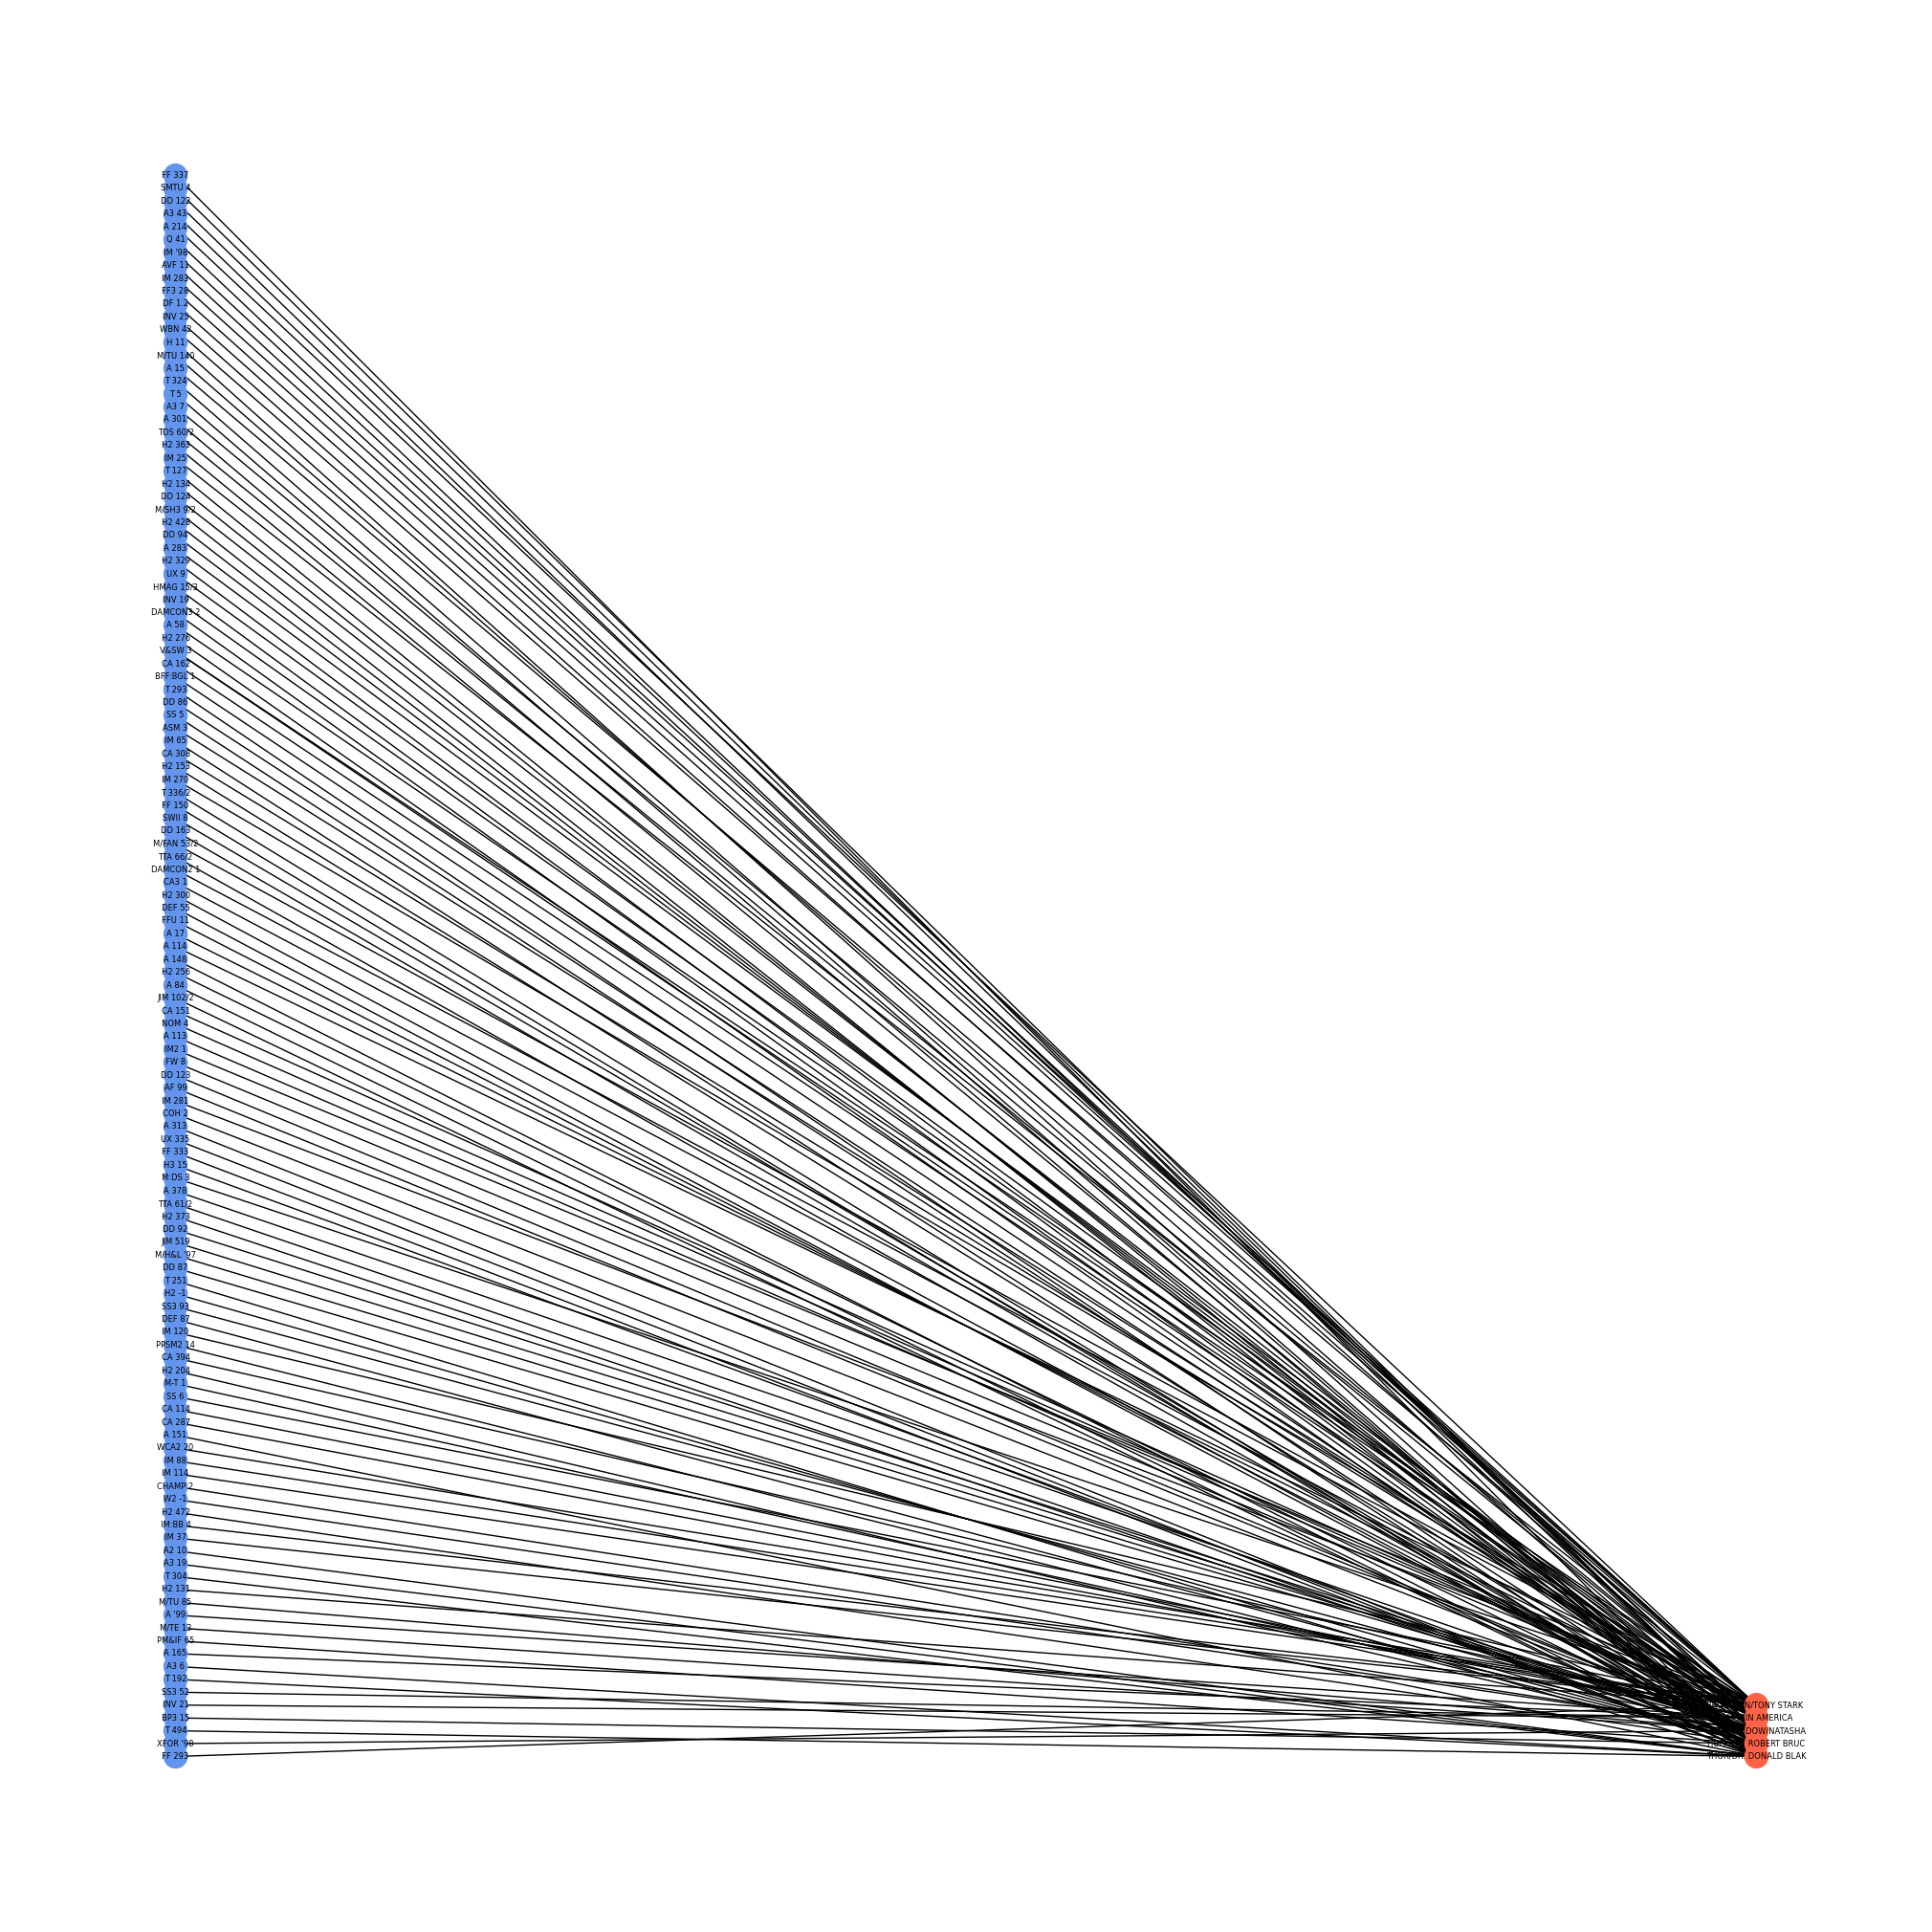

In [25]:
# create the bipartite graph
avenger_bipart = nx.Graph()

# add nodes and edges
avenger_bipart.add_nodes_from(comic_list, bipartite=0)
avenger_bipart.add_nodes_from(avenger_list, bipartite=1)
avenger_bipart.add_edges_from(edge_list)

# separate nodes
top_nodes_subset = {n for n, d in avenger_bipart.nodes(data=True) if d['bipartite'] == 0}
bottom_nodes_subset = set(avenger_bipart) - top_nodes_subset
avenger_bipart.nodes(data=True)

# set node colors
color_dict = {0:'cornflowerblue', 1:'tomato'}
color_list = [color_dict[i[1]] for i in avenger_bipart.nodes.data('bipartite')]

# draw a bipartite graph
pos = dict()
color = []
plt.figure(figsize = (20,20))
pos.update((n, (1, i)) for i, n in enumerate(top_nodes_subset)) 
pos.update((n, (2, i)) for i, n in enumerate(bottom_nodes_subset)) 
nx.draw(avenger_bipart, pos=pos, with_labels=True, node_color=color_list, font_size=6)
plt.show()


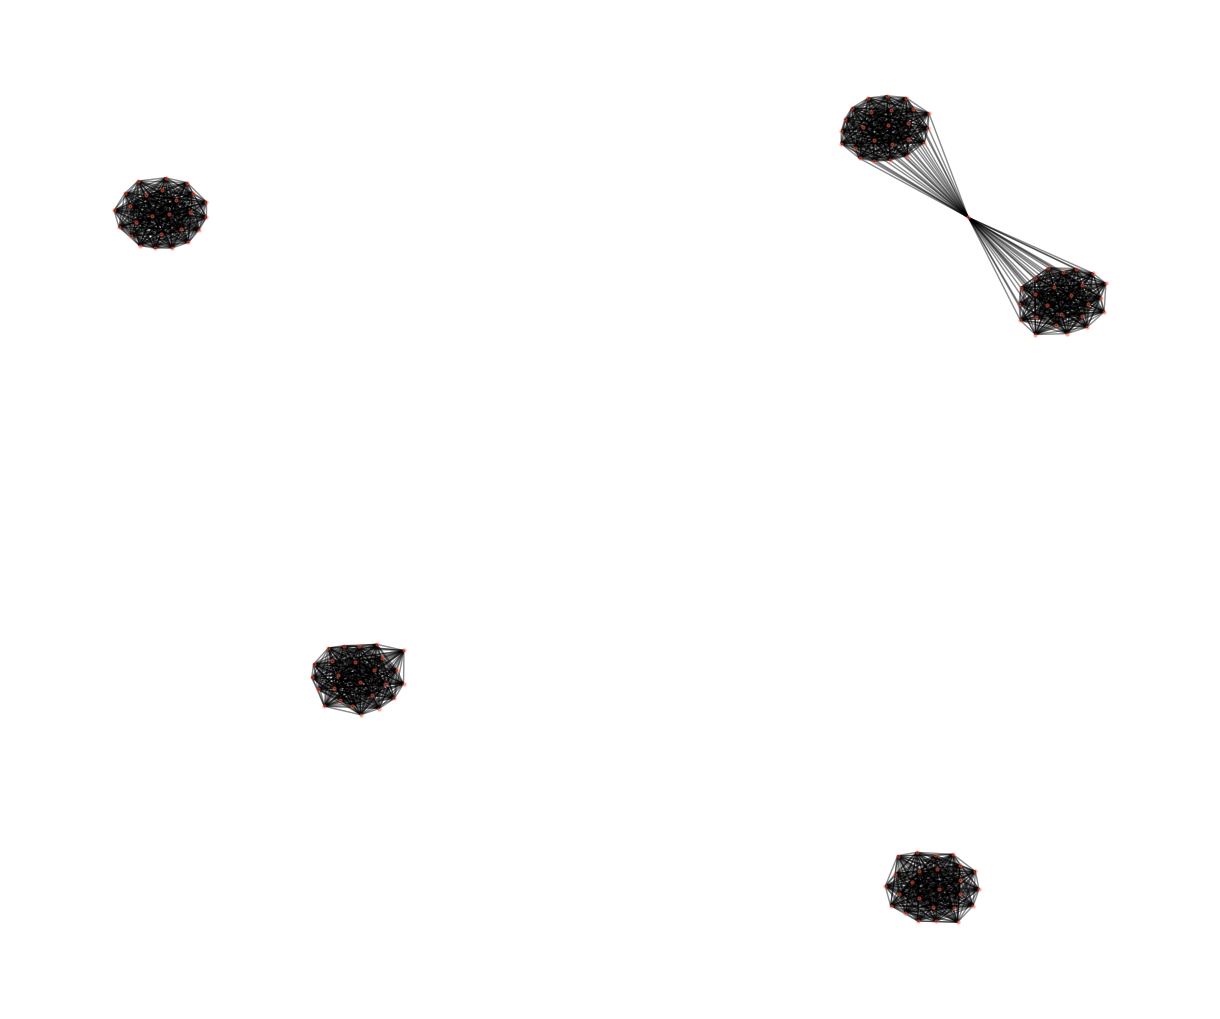

In [52]:
avenger_graph = bipartite.projected_graph(avenger_bipart, comic_list, multigraph=False)

pos=nx.spring_layout(avenger_graph)
nx.draw(avenger_graph, pos=pos, node_size=5, node_color='tomato', alpha=0.4)
nx.draw_networkx_edges(avenger_graph, pos=pos, alpha=0.1)
plt.show()

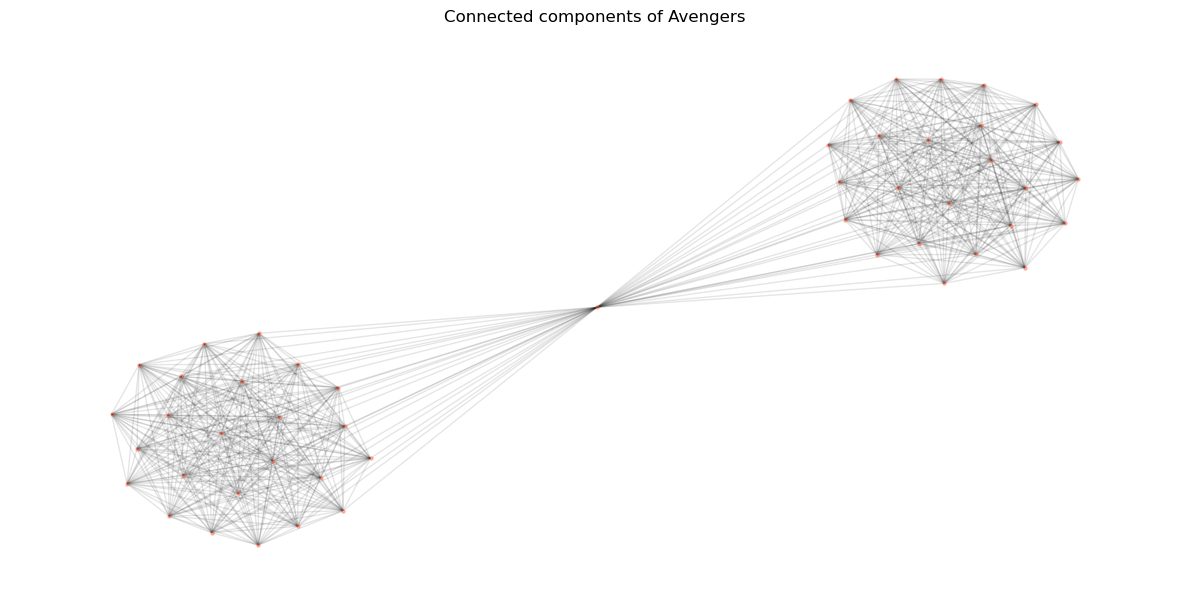

In [55]:
# Ranking of nodes regarding the number of degrees
degree_sequence = sorted([d for n, d in avenger_graph.degree()], reverse=True)

# Extract connected nodes to visualize
Gcc = avenger_graph.subgraph(sorted(nx.connected_components(avenger_graph), key=len, reverse=True)[0])

# Visualization
fig = plt.figure("Degree of the avenger graph")
axgrid = fig.add_gridspec(5, 4)
ax0 = fig.add_subplot(axgrid[0:3, :])
pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=5, alpha=0.4, node_color='tomato')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.1)
ax0.set_title("Connected components of Avengers")
ax0.set_axis_off()

fig.tight_layout()
plt.show()

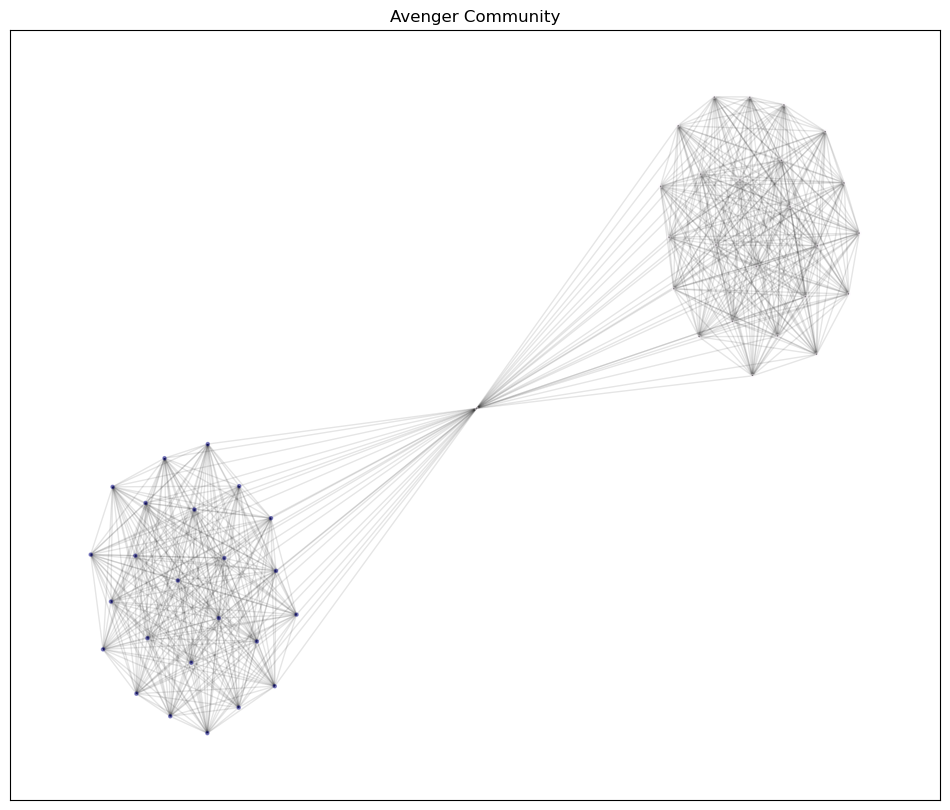

In [56]:
# Community division
partition_avenger = community_louvain.best_partition(Gcc)

# Color the nodes according to community
cmap = cm.get_cmap('gist_ncar', max(partition_avenger.values()) + 1)

pos = nx.spring_layout(Gcc, seed=42)
nx.draw_networkx_nodes(Gcc, pos, partition_avenger.keys(), node_size=5, alpha=0.4,
                       cmap=cmap, node_color=list(partition_avenger.values()))
nx.draw_networkx_edges(Gcc, pos, alpha=0.1)
plt.title("Avenger Community")
plt.show()